<h1 style="text-align:center;"> CS6700: Home Work 4 </h1>
<h3 style="text-align:center;"> Avinash G. Kori | ED15B006 </h3>
<hr>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def imshow(args):
    if len(args)==1:
        plt.imshow(args[0], interpolation='none')
    else:
        n=int(len(args)**0.5)
        plt.figure(figsize=(15, 15))
        for i in range(len(args)):
            plt.subplot(n + 1, n,i+1)
            plt.imshow(args[i])
    plt.show()


# Question 1

### Q1. 1> Value and policy iteration Implementation, in ipython notebook

In [2]:
class Question2(object):
    def __init__(self, variant = 1):
        """
            The objective of this question is to compare value iteration and policy iteration on a 10 × 10
            gridworld based on the actions, rewards and the state space given below.
            variant: variant of grid world
            variant = 1 (terminal state at (3, 0))
            variant = 2 (terminal state at (9, 9))
        """
        self.variant = variant
        # init Probabilities
        self.P = np.zeros((10, 10, 4, 10, 10))
        self.J = np.zeros((1, 1, 1, 10, 10))
        self.Jpi = np.zeros((1, 1, 1, 10, 10))
        # init all rewards with 0
        self.g = np.zeros((10, 10, 4, 10, 10))    
        # wormhole locations
        self.wormholeIN = np.array([
                    [(0,0)],
                    [(7,9)]
                    ])
        self.wormholeOUT = np.array([
                    [(2, 3), (2, 4), (2, 5), (2, 6)],
                    [(7, 1)]
                    ])
        # generate Probabilities
        self.P = self.generateP()
        # generate Rewards
        self.g = self.generateR()
        self.alpha = 0.7
        
    def generateP(self):
        """
            Generates and returns P matrix 
            5th order Tensor
        """
        for ix in range(self.P.shape[0]):
            for iy in range(self.P.shape[1]):
                for action in range(self.P.shape[2]):
                    temp = np.zeros((10, 10))
                    if action == 0: 
                        temp[ix, min(iy + 1, 9)] = 0.8 
                        temp[ix, max(iy - 1, 0)] = 0.2/3.0
                        temp[max(0, ix - 1), iy] = 0.2/3.0 
                        temp[min(ix + 1, 9), iy] = 0.2/3.0
                    elif action == 1:
                        temp[ix, min(iy + 1, 9)] = 0.2/3. 
                        temp[ix, max(iy - 1, 0)] = 0.2/3. 
                        temp[max(ix - 1, 0), iy] = 0.2/3. 
                        temp[min(ix + 1, 9), iy] = 0.8 
                    elif action == 2:
                        temp[ix, max(iy - 1, 0)] = 0.8
                        temp[ix, min(iy + 1, 9)] = 0.2/3.
                        temp[min(ix + 1, 9), iy] = 0.2/3.
                        temp[max(ix - 1, 0), iy] = 0.2/3.
                    else:
                        temp[max(ix - 1, 0), iy] = 0.8
                        temp[min(ix + 1, 9), iy] = 0.2/3.
                        temp[ix, min(iy + 1, 9)] = 0.2/3.
                        temp[ix, max(iy - 1, 0)] = 0.2/3.
                    
                    if (ix, iy) == (0, 0):
                        temp = np.zeros((10, 10))
                        temp[2, 3] = temp[2, 4] = temp[2, 5] = temp[2, 6] = 1/4.0
                    
                    if (ix, iy) == (7, 9):
                        temp = np.zeros((10, 10))
                        temp[7, 1] = 1.0
                        
#                     for wi in range(len(self.wormholeIN)):
#                         if (ix, iy) in self.wormholeIN[wi]:
#                             temp = np.zeros((10, 10))
#                             for o in self.wormholeOUT[wi]:
#                                 temp[o[0], o[1]] = 1.0/len(self.wormholeOUT[wi])
                    
                    if ((ix, iy) == (3, 0) and self.variant == 1) \
                       or (self.variant == 2 and (ix, iy) == (9, 9)):
                        temp = np.zeros((10, 10))

                    self.P[ix, iy, action, :, :] = temp
        return self.P
    
    def generateR(self):
        """
            Generates and returns R matrix 
            5th order Tensor
        """
        for ix in range(self.P.shape[0]):
            for iy in range(self.P.shape[1]):
                for action in range(self.P.shape[2]):
                    if self.variant == 2 and \
                    ((ix, iy, action) == (8, 9, 1) or \
                        (ix, iy, action) == (9, 8, 0)):
                        self.g[ix, iy, action, 9, 9] = 10
                        
                    if self.variant == 1 and \
                     ((ix, iy, action) == (2, 0, 1) or \
                        (ix, iy, action) == (3, 1, 2)\
                        or(ix, iy, action) == (4, 0, 3)):
                        self.g[ix, iy, action, 3, 0] = 10
        return self.g
                        
    def Toperator(self, J):
        """
            Applies T operator for current J
        """
        J = np.max(np.sum(self.P*(self.g + self.alpha*J),\
                            axis=(3, 4)), axis=2)
        return J
    
    def optPolicy(self, J):
        """
            Finds optimal policy for current states
        """
        optP = np.argmax(np.sum(self.P*(self.g + self.alpha*J),\
                            axis=(3, 4)), axis=2)
        return optP
    
    def Tpioperator(self, Policy, Jpi):
        """
            Applies Tpi operator for current Jpi
        """
        P = np.zeros((self.P.shape[0], self.P.shape[0],\
                     self.P.shape[0], self.P.shape[0]))
        G = np.zeros((self.g.shape[0], self.g.shape[0],\
                     self.g.shape[0], self.g.shape[0]))
        
        for i in range(len(Policy)):
            for j in range(len(Policy[0])):
                P[i,j, :, :] = self.P[i, j, Policy[i, j], :, :]
                G[i,j, :, :] = self.g[i, j, Policy[i, j], :, :]
                
        P = P.reshape(100, 100)
        G = G.reshape(100, 100)
        Jpi = Jpi.reshape(100, 1)
        
        Jpi = np.sum(P*G, axis=1)[:, None] + self.alpha*P.dot(Jpi)
        Jpi = Jpi.reshape(1, 1, 1, 10, 10)
        return Jpi
    
    def PolicyEvaluation(self, Policy, J, M = 1000):
        """
            Policy evaluation function
        """
        if M:
            for _ in range(M):
                J = self.Tpioperator(Policy, J)
        else:
#             I = np.zeros((self.P.shape[0], self.P.shape[0],\
#                           self.P.shape[0], self.P.shape[0]))
#             for i in range(self.P.shape[0]):
#                 for j in range(self.P.shape[0]):
#                     I[i,j, :, :] = np.eye(self.P.shape[0])

            I = np.eye(100)
            P = np.zeros((self.P.shape[0], self.P.shape[0],\
                          self.P.shape[0], self.P.shape[0]))
            G = np.zeros((self.P.shape[0], self.P.shape[0],\
                          self.g.shape[0], self.g.shape[0]))
            
            for i in range(len(Policy)):
                for j in range(len(Policy)):
                    P[i,j, :, :] = self.P[i,j, Policy[i, j], :, :]
                    G[i,j, :, :] = self.g[i,j, Policy[i,j], :, :]
            
            P = P.reshape(100, 100)
            G = G.reshape(100, 100)
            
            J = np.sum(P*G, axis=1)[None, :].dot(np.linalg.inv(I - self.alpha*P))
#             J = np.sum(P*G, axis = (2,3)).dot(np.linalg.inv(I - self.alpha*P).sum((2,3)))
#             print J.shape
            J = J.reshape(1,1,1,10,10)
        return J
    
    def PolicyUpdate(self, Jpi):
        """
            Tpi_new Jpi = TJpi finds new policy
        """
        Policy = self.optPolicy(Jpi)
        return Policy
    
    def ValueIteration(self, N = 1000):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        cost_hist, policy_hist = [], []
        temp = np.zeros((10,10))
        for _ in range(N): 
            self.J = self.Toperator(self.J)
            self.optP = self.optPolicy(self.J)
#             print "Value Iteration", _
#             print self.optP
            cost_hist.append(np.rot90(self.J.reshape(10, 10)))
            policy_hist.append(np.rot90(self.optP.reshape(10, 10)) - temp)
            temp = np.rot90(self.optP.reshape(10, 10))
        return list(self.J.reshape(10, 10)), list(self.optP.reshape(10,10)), cost_hist, policy_hist  
    
    def PolicyIteration(self, N = 1000, M = 100):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        cost_hist, policy_hist = [], []
        
        self.Policy = np.zeros((10, 10), dtype='int32')
        temp = np.zeros((10,10))
        for _ in range(N): 
            self.Jpi  = self.PolicyEvaluation(self.Policy, self.Jpi, M)
            self.Policy = self.PolicyUpdate(self.Jpi)
#             print "Policy Iteration", _
#             print self.Policy
            cost_hist.append(np.rot90(self.Jpi.reshape(10, 10)))
            policy_hist.append(np.rot90(self.Policy.reshape(10, 10))- temp)
            temp = np.rot90(self.Policy.reshape(10, 10))
        return list(self.Jpi.reshape(10,10)), list(self.Policy.reshape(10,10)), cost_hist, policy_hist
    
from unicodedata import *
def print_policy(pi, variant = 2):
    pi = np.array(pi)
    pi[0,0]=4
    pi[7,9]=4
    
    if variant == 1:
        pi[9, 9] = 5
    else:
        pi[3, 0] = 5

    plot = np.empty((10,10), dtype='str')
        
    print '--------------------------------'
    plot[np.where(pi == 0)] = '^'
    plot[np.where(pi == 1)] = '>'
    plot[np.where(pi == 2)] = 'v'
    plot[np.where(pi == 3)] = '<'
    plot[np.where(pi == 4)] = 'W'
    plot[np.where(pi == 5)] = 'T'

    print np.rot90(plot)
            
    print '--------------------------------'

##### 2.a) Plot graph of maxs |Ji+1(s) − Ji(s)| vs iterations and Ps πi+1(s) 6= πi(s) vs iterations for both value iteration and policy iteration.

================== Value Iteration Plots ===============


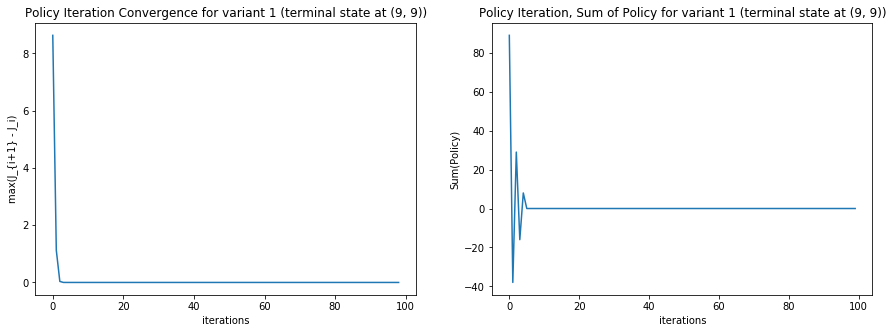

================== Policy Iteration Plots ===============


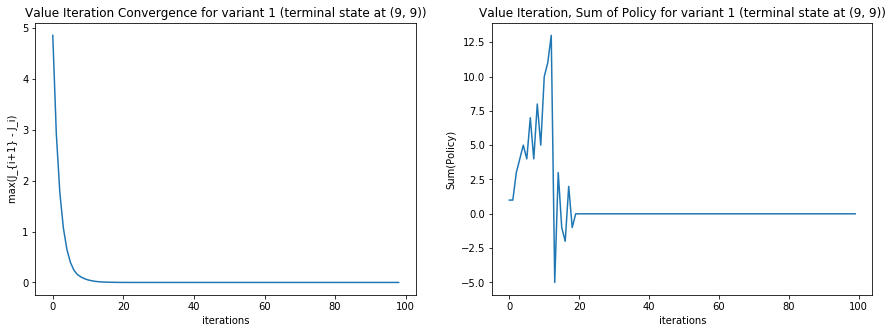

In [3]:
print "================== Value Iteration Plots ==============="

question2 = Question2(2)
j, p, Cpv1hist, Ppv1hist = question2.PolicyIteration(N=100)

diff_hist = np.diff(np.array(Cpv1hist), axis = 0)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.max(diff_hist, axis = (1,2)))
plt.title('Policy Iteration Convergence for variant 1 (terminal state at (9, 9))')
plt.xlabel('iterations')
plt.ylabel('max(J_{i+1} - J_i)')

plt.subplot(1, 2, 2)
plt.plot(np.sum(np.array(Ppv1hist), axis = (1,2)))
plt.title('Policy Iteration, Sum of Policy for variant 1 (terminal state at (9, 9))')
plt.xlabel('iterations')
plt.ylabel('Sum(Policy)')
plt.show()

print "================== Policy Iteration Plots ==============="

question2 = Question2(2)
j, p, Cvv1hist, Pvv1hist = question2.ValueIteration(N=100)

diff_hist = np.diff(np.array(Cvv1hist), axis = 0)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.max(diff_hist, axis = (1,2)))
plt.title('Value Iteration Convergence for variant 1 (terminal state at (9, 9))')
plt.xlabel('iterations')
plt.ylabel('max(J_{i+1} - J_i)')

plt.subplot(1, 2, 2)
plt.plot(np.sum(np.array(Pvv1hist), axis = (1,2)))
plt.title('Value Iteration, Sum of Policy for variant 1 (terminal state at (9, 9))')
plt.xlabel('iterations')
plt.ylabel('Sum(Policy)')
plt.show()

##### 2.b) Compare value iteration and policy iteration by plotting J(s) vs iterations for three random states. Which converges faster? Why?

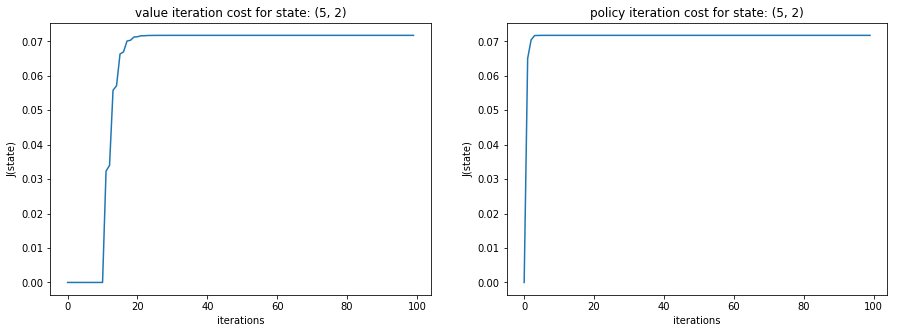

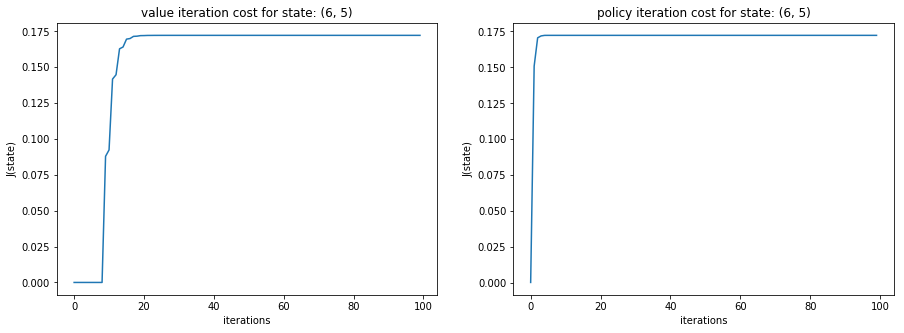

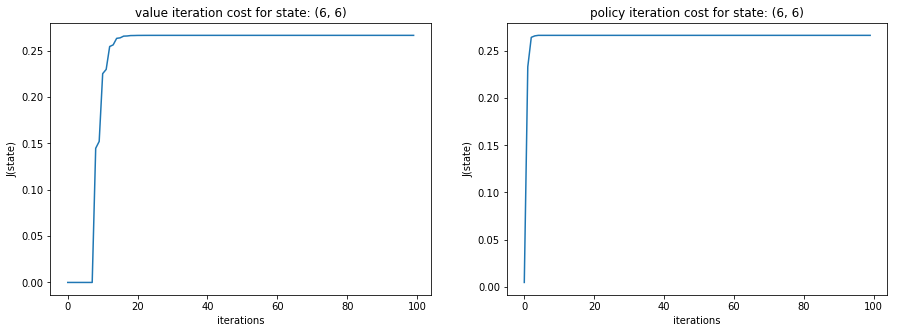

In [4]:
states = zip(np.random.randint(9, size = 3), np.random.randint(9, size = 3))

for (x,y) in states:
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(Cvv1hist)[:, x, y])
    plt.title('value iteration cost for state: ({}, {})'.format(x,y))
    plt.xlabel('iterations')
    plt.ylabel('J(state)')
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(Cpv1hist)[:, x, y])
    plt.title('policy iteration cost for state: ({}, {})'.format(x,y))
    plt.xlabel('iterations')
    plt.ylabel('J(state)')
    plt.show()

#####  Convergence of policy iteration is faster: Value iteration takes about 15-20 iterations to converge, but policy iteration converges with in 5 iterations
+ In case of policy iteration each policy updated policy should be better than it's previous policy
+ In case of policy iteration closed loop simultanious equations are solved to find optimal cost (policy evaluation step), but in case of value iteration simultanious equations are solved in iterative fashion 

##### 2.c) Show J(s) and greedy policy π(s), ∀s, obtained after 5 iterations, and after you stop value iteration. 

#### value iteration stops after 20 iterations...

=========== ValueIteration (N = 5) =============


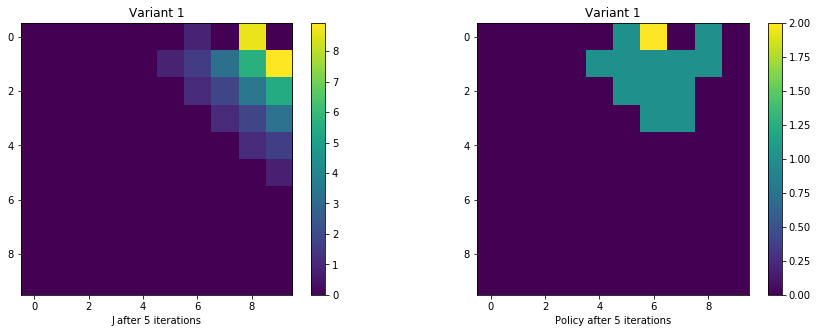

--------------------------------
[['^' '^' '^' '^' '^' '>' 'v' 'W' '>' 'T']
 ['^' '^' '^' '^' '>' '>' '>' '>' '>' '^']
 ['^' '^' '^' '^' '^' '>' '>' '>' '^' '^']
 ['^' '^' '^' '^' '^' '^' '>' '>' '^' '^']
 ['^' '^' '^' '^' '^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^' '^' '^' '^' '^']
 ['W' '^' '^' '^' '^' '^' '^' '^' '^' '^']]
--------------------------------
==== ValueIteration(N = 20) after convergence of value iteration =====


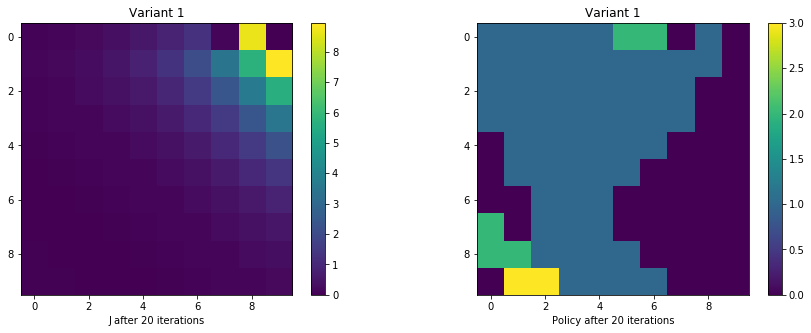

--------------------------------
[['>' '>' '>' '>' '>' 'v' 'v' 'W' '>' 'T']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['^' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '>' '>' '>' '>' '>' '^' '^' '^' '^']
 ['^' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' 'v' '>' '>' '>' '>' '^' '^' '^' '^']
 ['W' '<' '<' '>' '>' '>' '>' '^' '^' '^']]
--------------------------------


In [5]:
print ("=========== ValueIteration (N = 5) =============")
question2 = Question2(2)
j, p, Chist, Phist = question2.ValueIteration(N=5)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("J after 5 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("Policy after 5 iterations")
plt.show()
print_policy(p, 1)

print ("==== ValueIteration(N = 20) after convergence of value iteration =====")

question2 = Question2(2)
j, p, Chist, Phist = question2.ValueIteration(N=20)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("J after 20 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("Policy after 20 iterations")
plt.show()
print_policy(p, 1)

##### 2.d) Show J(s) and greedy policy π(s), ∀s, obtained after 5 iterations, and after you stop policy iteration. 

#### policy iteration stops after 4 iterations

=========== PolicyIteration(N = 5) ===============


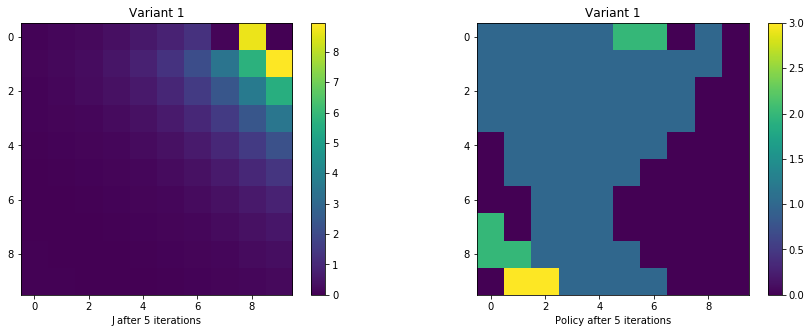

--------------------------------
[['>' '>' '>' '>' '>' 'v' 'v' 'W' '>' 'T']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['^' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '>' '>' '>' '>' '>' '^' '^' '^' '^']
 ['^' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' 'v' '>' '>' '>' '>' '^' '^' '^' '^']
 ['W' '<' '<' '>' '>' '>' '>' '^' '^' '^']]
--------------------------------
=== PolicyIteration(N = 5) after convergence of policy iteration =====


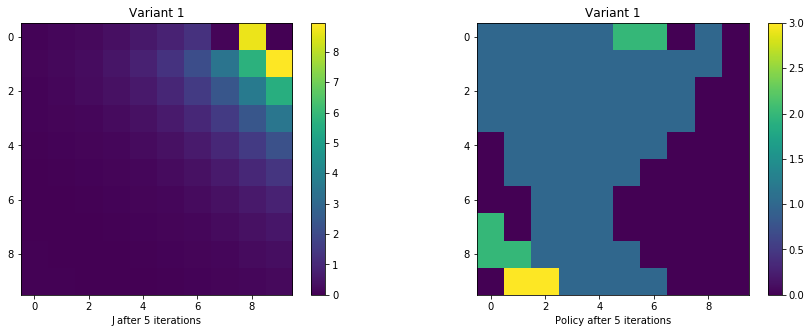

--------------------------------
[['>' '>' '>' '>' '>' 'v' 'v' 'W' '>' 'T']
 ['>' '>' '>' '>' '>' '>' '>' '>' '>' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['>' '>' '>' '>' '>' '>' '>' '>' '^' '^']
 ['^' '>' '>' '>' '>' '>' '>' '^' '^' '^']
 ['^' '>' '>' '>' '>' '>' '^' '^' '^' '^']
 ['^' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' '^' '>' '>' '>' '^' '^' '^' '^' '^']
 ['v' 'v' '>' '>' '>' '>' '^' '^' '^' '^']
 ['W' '<' '<' '>' '>' '>' '>' '^' '^' '^']]
--------------------------------


In [6]:
print ("=========== PolicyIteration(N = 5) ===============")
question2 = Question2(2)
j, p, Chist, Phist = question2.PolicyIteration(N=5)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("J after 5 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("Policy after 5 iterations")
plt.show()
print_policy(p, 1)

print ("=== PolicyIteration(N = 5) after convergence of policy iteration =====")

question2 = Question2(2)
j, p, Chist, Phist = question2.PolicyIteration(N=5)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("J after 5 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 1")
plt.xlabel("Policy after 5 iterations")
plt.show()
print_policy(p, 1)

##### 2.e)  Explain the behaviour of J and greedy policy π obtained by value iteration and policy iteration.
+ Policy in all the states lead to terminal state, it can even be observed in the policies around wormhole, around wormhole (7, 9) any policy is not directed towards (7, 9), while around wormhole (0, 0) all the policies are leading towards (0,0)  
+ Cost around terminal state high as compared to any other states
+ Cost for all the states remain constant after convergence, Convergence in case of value iteration needs about 25 iteration while policy iteration just needs 5 iterations

##### 3.a)  Show J(s) and policy π(s), ∀s, obtained after you stop value iteration and policy iteration and explain it’s behaviour.

======== value iteration stops at 20th iteration ==============


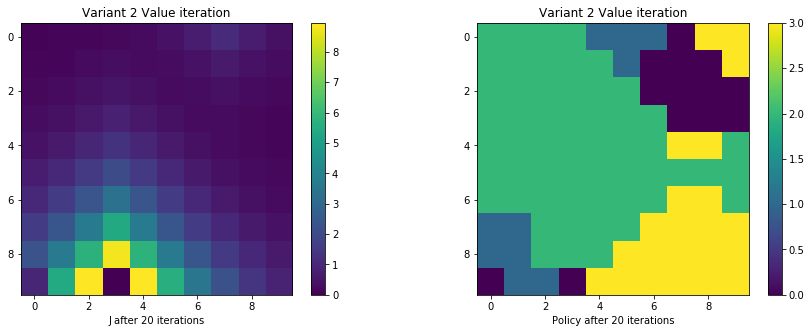

--------------------------------
[['v' 'v' 'v' 'v' '>' '>' '>' 'W' '<' '<']
 ['v' 'v' 'v' 'v' 'v' '>' '^' '^' '^' '<']
 ['v' 'v' 'v' 'v' 'v' 'v' '^' '^' '^' '^']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '^' '^' '^']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '<' '<' 'v']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '<' '<' 'v']
 ['>' '>' 'v' 'v' 'v' 'v' '<' '<' '<' '<']
 ['>' '>' 'v' 'v' 'v' '<' '<' '<' '<' '<']
 ['W' '>' '>' 'T' '<' '<' '<' '<' '<' '<']]
--------------------------------
======= policy iteration stops at 5th iteration ==============


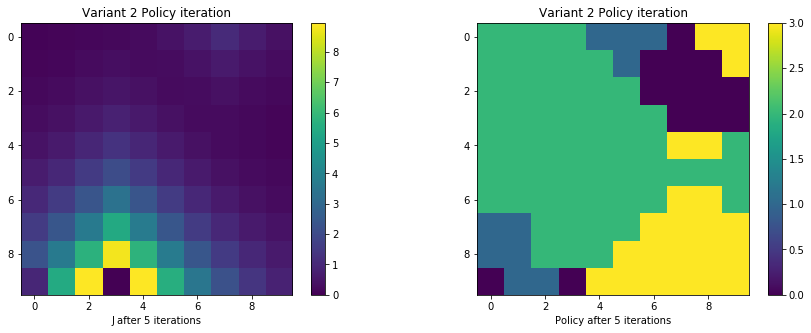

--------------------------------
[['v' 'v' 'v' 'v' '>' '>' '>' 'W' '<' '<']
 ['v' 'v' 'v' 'v' 'v' '>' '^' '^' '^' '<']
 ['v' 'v' 'v' 'v' 'v' 'v' '^' '^' '^' '^']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '^' '^' '^']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '<' '<' 'v']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v']
 ['v' 'v' 'v' 'v' 'v' 'v' 'v' '<' '<' 'v']
 ['>' '>' 'v' 'v' 'v' 'v' '<' '<' '<' '<']
 ['>' '>' 'v' 'v' 'v' '<' '<' '<' '<' '<']
 ['W' '>' '>' 'T' '<' '<' '<' '<' '<' '<']]
--------------------------------


In [8]:
print ("======== value iteration stops at 20th iteration ==============")

question2 = Question2(1)
j, p, Chist, Phist = question2.ValueIteration(N=20)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 2 Value iteration")
plt.xlabel("J after 20 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 2 Value iteration")
plt.xlabel("Policy after 20 iterations")
plt.show()
print_policy(p, 2)

print ("======= policy iteration stops at 5th iteration ==============")

question2 = Question2(1)
j, p, Chist, Phist = question2.PolicyIteration(N=5)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(j))
plt.colorbar()
plt.title("Variant 2 Policy iteration")
plt.xlabel("J after 5 iterations")
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(p))
plt.colorbar()
plt.title("Variant 2 Policy iteration")
plt.xlabel("Policy after 5 iterations")
plt.show()
print_policy(p, 2)

+ Policy in all the states lead to terminal state, it can even be observed in the policies around wormhole, around wormhole (7, 9) as all the policies are directing towards (7, 9), while around wormhole (0, 0) no policies are directing, as (3, 0) is terminal state
+ Cost around terminal state and (7,9) wormhole is high as compared to any other states
+ Cost for all the states remain constant after convergence, Convergence in case of value iteration needs about 25 iteration while policy iteration just needs 5 iterations





<hr>

# Question 2

In [88]:
class Question1(object):
    """
    Consider a problem of a taxi driver, who serves three cities A, B and C. The taxi driver can find a
    new ride by choosing one of the following actions.
    1. Cruise the streets looking for a passenger.
    2. Go to the nearest taxi stand and wait in line.
    3. Wait for a call from the dispatcher (this is not possible in town B because of poor reception).
    For a given town and a given action, there is a probability that the next trip will go to each of the
    towns A, B and C and a corresponding reward in monetary units associated with each such trip.
    This reward represents the income from the trip after all necessary expenses have been deducted.
    Please refer Table 1 below for the rewards and transition probabilities. In Table 1 below, p
    kij is the probability of getting a ride to town j, by choosing an action k while the driver was in town i and r
    kij is the immediate reward of getting a ride to town j, by choosing an action k while the driver was in
    town i.
    """
    def __init__(self, alpha = 0.95):
        # define probabilities
        self.P = np.array([
                [[0.5   , 0.25 , 0.250 ],
                 [1./16., 3./4., 3./16.],
                 [1./4. , 1./8., 5./8. ]],
                [[1./2. , 0.   , 1./2. ],
                 [1./16. , 7./8., 1./16.],
                 [0.    ,   1. , 0     ]],
                [[1./4. , 1./4., 1./2. ],
                 [1./8. , 3./4., 1./8. ],
                 [3./4. ,1./16., 3./16.]]
            ])
#         self.P = np.swapaxes(self.P, 1, 0) # S, a, S'
        
        # define rewards
        self.g = np.array([
                [[10., 4., 8.],
                 [8.,  2., 4.],
                 [4.,  6., 4.]],
                [[14., 0., 18.],
                 [8., 16., 08.],
                 [0.,  0., 0. ]],
                [[10., 2., 8. ],
                 [6. , 4., 2. ],
                 [4. , 0., 8.]]
            ])
#         self.g = np.swapaxes(self.g, 1, 0) # S, a, S'
        # init J
        self.alpha = alpha
        self.J = np.array([[[0., 0., 0.]]]) # 1x1x3
        self.Jpi = np.array([[[0., 0., 0.]]]) # 1x1x3
        
    def Toperator(self, J):
        """
            Applies T operator for current J
        """
        J = np.max(np.sum(self.P*(self.g + self.alpha*J), axis=2), axis=1)
        return J
    
    def optPolicy(self, J):
        """
            Finds optimal policy for current states
        """
        optP = np.argmax(np.sum(self.P*(self.g + self.alpha*J), axis=2), axis=1)
        return optP 
    
    def Tpioperator(self, Policy, Jpi):
        """
            Applies Tpi operator for current Jpi
        """
        P = np.zeros((self.P.shape[0], self.P.shape[0]))
        G = np.zeros((self.g.shape[0], self.g.shape[0]))
        for i in range(len(Policy)):
            P[:, i] = self.P[i, Policy[i],:]
            G[:, i] = self.g[i, Policy[i],:]
            
        Jpi = np.sum(P*G, axis=1)[:, None] + self.alpha*P.dot(Jpi.reshape(3, 1))
        Jpi = Jpi.reshape(1,1,3)
        return Jpi
    
    def PolicyEvaluation(self, Policy, J, M = 10):
        """
            Policy evaluation function
            M = None, performs policy evaluation
            M > 0, performs modified policy evaluation
        """
        if M:
            for _ in range(M):
                J = self.Tpioperator(Policy, J)
        else:
            I = np.eye(self.P.shape[0])
            P = np.zeros((self.P.shape[0], self.P.shape[0]))
            G = np.zeros((self.g.shape[0], self.g.shape[0]))
            for i in range(len(Policy)):
                P[:, i] = self.P[i, Policy[i], :]
                G[:, i] = self.g[i, Policy[i], :]
            J = np.sum(P*G, axis=1)[None, :].dot(np.linalg.inv(I - self.alpha*P))
            J = J.reshape(1,1,3)
        return J
    
    def PolicyUpdate(self, Jpi):
        """
            Tpi_new Jpi = TJpi finds new policy
        """
        Policy = self.optPolicy(Jpi)
        return Policy
    
    def ValueIteration(self, N = 1000):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        for _ in range(N): 
#             print "Value Iteration,", _
            self.J    = self.Toperator(self.J)
            self.optP = self.optPolicy(self.J)    
#             print self.J, self.optP
        return self.J.reshape(3), self.optP.reshape(3)

    def GaussSeidelValueIteration(self, N = 1000):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        for ii in range(N): 
#             print "Value Iteration,", _
#             state   = np.random.randint(3)
            state = ii % 3
            self.J[:, :, state]  = np.max(np.sum(self.P[state, :, :]*\
                                        (self.g[state, :, :] + self.alpha*\
                                         self.J[0]), axis=1), axis=0)
            self.optP = self.optPolicy(self.J)    
#             print self.J, self.optP
        return self.J.reshape(3), self.optP.reshape(3)
    
    def PolicyIteration(self, N = 1000):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        self.Policy = np.array([1, 1, 1])
        temp = np.array([0,0,0])
        for _ in range(N):
#             print "Policy Iteration,", _
            self.Jpi  = self.PolicyEvaluation(self.Policy, self.Jpi, M=None)
            self.Policy = self.PolicyUpdate(self.Jpi)
#             print self.Jpi, self.Policy
            if temp.all() == self.Policy.all(): break
            temp = self.Policy
        return self.Jpi.reshape(3), self.Policy.reshape(3)
            
    def ModifiedPolicyIteration(self, N = 1000, M = 5):
        """
            Input Args:
                N: number of iterations
            returns:
                J: optimal J
                P: optimal policy
        """
        self.Policy = np.array([1,1,1])
        temp = np.array([0,0,0])
        for _ in range(N): 
#             print "Modified Policy Iteration,", _
            self.Jpi  = self.PolicyEvaluation(self.Policy, self.Jpi, 5)
            self.Policy = self.PolicyUpdate(self.Jpi)
#             print self.Jpi, self.Policy
            if temp.all() == self.Policy.all(): break
            temp = self.Policy
        return self.Jpi.reshape(3), self.Policy.reshape(3)
    

    
question1 = Question1()
vcost10_, vpolicy10_ = question1.ValueIteration(N = 10)
pcost10_, ppolicy10_ = question1.PolicyIteration(N = 10)
mpcost10_, mppolicy10_ = question1.ModifiedPolicyIteration(N = 10)


question1 = Question1()
vcost20_, vpolicy20_ = question1.ValueIteration(N = 20)
pcost20_, ppolicy20_ = question1.PolicyIteration(N = 20)
mpcost20_, mppolicy20_ = question1.ModifiedPolicyIteration(N = 20)

##### 1) Find an optimal policy using policy iteration starting with a policy that will always cruise independent of the town. Solve it for discount factors β ranging from 0 to 0.95 with intervals of 0.05. Tabulate the optimal policies and optimal values obtained for different values of β. (5marks)

In [96]:
V={'alpha':[], 'cost': [], 'policy': []}
P={'alpha':[], 'cost': [], 'policy': []}
PM={'alpha':[], 'cost': [], 'policy': []}

# print "=================== Value Iteration ========================"  
for alpha in range(0, 95, 5):
    alpha = alpha*1.0/100.0
    
    question1 = Question1(alpha)
    vcost, vpolicy   = question1.PolicyIteration(N = 10)
    V['alpha'].append(alpha)
    V['cost'].append(vcost)
    V['policy'].append(vpolicy)
#     print str(alpha) + "     " + str(vcost) + "     " + str(vpolicy+1)
    
# print "==================== Modified Policy Iteration =================="  
for alpha in range(0, 95, 5):
    alpha = alpha*1.0/100.0
    
    question1 = Question1(alpha)  
    pcost, ppolicy   = question1.ModifiedPolicyIteration(N = 10)
    P['alpha'].append(alpha)
    P['cost'].append(vcost)
    P['policy'].append(vpolicy)
#     print alpha, pcost, ppolicy+1
    
print "===================== Policy Iteration ========================"  
print ('alpha        ', '       cost          ', '       policy')
for alpha in range(0, 95, 5):
    alpha = alpha*1.0/100.0
    
    question1 = Question1(alpha)
    mpcost, mppolicy = question1.ValueIteration(N = 100)
    PM['alpha'].append(alpha)
    PM['cost'].append(vcost)
    PM['policy'].append(vpolicy)
    print str(alpha) + "     " + str(mpcost) + "     " + str(mppolicy+1)

#     print (list(V['alpha']), list(V['cost']), list(V['policy']))

===================== Policy Iteration ========================
('alpha        ', '       cost          ', '       policy')
0.0     [ 8. 16.  7.]     [1 1 1]
0.05     [ 8.51152729 16.40025991  7.49886907]     [1 1 1]
0.1     [ 9.07650615 16.85636856  8.05086512]     [1 1 1]
0.15     [ 9.70812149 17.46450304  8.66916045]     [1 2 1]
0.2     [10.43703008 18.48214286  9.3843985 ]     [1 2 1]
0.25     [11.27407407 19.62962963 10.20740741]     [1 2 1]
0.3     [12.24383724 20.93406593 11.16275616]     [1 2 1]
0.35     [13.37871444 22.43076923 12.28282403]     [1 2 1]
0.4     [14.72222222 24.16666667 13.61111111]     [1 2 1]
0.45     [16.33413127 26.2055336  15.20737071]     [1 2 1]
0.5     [18.2987013  28.63636364 17.15584416]     [1 2 1]
0.55     [20.78998864 31.6073967  19.83072522]     [1 2 2]
0.6     [24.02568645 35.32772365 23.45881311]     [1 2 2]
0.65     [28.27669207 40.09628059 28.1299788 ]     [1 2 2]
0.7     [34.06193078 46.43541617 34.36604102]     [1 2 2]
0.75     [42.3174114  5

##### 2.a)  Find an optimal policy using modified policy iteration. Let mk = 5 ∀k. Start with a policy that will always cruise independent of the town. Let β = 0.9. What are the optimal values? (3 marks)

In [91]:
question1 = Question1(alpha = 0.9)
mpcost, mppolicy = question1.ModifiedPolicyIteration(N = 10, M = 5)

print "============ Modified Policy Iteration with M = 5 =================="  
print str(alpha) + "     " + str(mpcost) + "     " + str(mppolicy+1)

============ Modified Policy Iteration with M = 5 ==================
0.9     [  9.80458517 121.26398216  10.59387195]     [2 2 2]


##### 2.b) Do you find any improvement if you choose mk = 10 ∀k? Explain. (2 marks)

+ Both the policies are same, but cost needs to be converged
+ Modified policy iteration freezes the policies in finite number of steps, in this case as number of actions are just 3 

In [95]:
question1 = Question1(alpha = 0.9)
mpcost, mppolicy = question1.ModifiedPolicyIteration(N = 10, M = 10)

print "============ Modified Policy Iteration with M = 10 =================="  
print "Cost and Policy for state [A, B, C] are: " + str(mpcost) + " and " + str(mppolicy+1) + " respectively."

============ Modified Policy Iteration with M = 10 ==================
Cost and Policy for state [A, B, C] are: [  9.80458517 121.26398216  10.59387195] and [2 2 2] respectively.


##### 3.) Find an optimal policy using value iteration and Gauss-Seidel value iteration starting with a zero vector. Let β = 0.9. What are the optimal values? (5 marks)

In [94]:
question1 = Question1(alpha=0.9)
vcost, vpolicy = question1.ValueIteration(N = 150)
print "============ Value Iteration ============"
print "Cost and Policy for state [A, B, C] are: " + str(vcost) + " and " + str(vpolicy+1) + " respectively."


question1 = Question1(alpha=0.9)
gvcost, gvpolicy = question1.GaussSeidelValueIteration(N = 1500)
print "============ Gauss SeidelValue Iteration ============"
print "Cost and Policy for state [A, B, C] are: " + str(gvcost) + " and " + str(gvpolicy+1) + " respectively."

============ Value Iteration ============
Cost and Policy for state [A, B, C] are: [121.65345309 135.30625749 122.83688504] and [2 2 2] respectively.
============ Gauss SeidelValue Iteration ============
Cost and Policy for state [A, B, C] are: [121.65347112 135.30627552 122.83690308] and [2 2 2] respectively.


<hr>

### Reference
+ Prashanth L. A. CS6700: Reinforcement learning Course notes, 2018
+ Dimitri P. Bertsekas. Dynamic Programming and Optimal Control, vol. I. Athena Scientific, 2017.